# Classifying Events by Type

A similar application is the Facebook Event Classifier, which attempts to categorize events (e.g. parties, concerts, games).

In [29]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;

import string, nltk, re, pprint

from functools import reduce
from tqdm import tqdm
from pylab import *;
from scipy import sparse
from time import time

from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import lightgbm as lgb;

from wordcloud import WordCloud, STOPWORDS

eng_stopwords = set(stopwords.words("english"))

%matplotlib inline

In [2]:
events = pd.read_csv('raw_data/cleaned_up.csv')

## Feature Engineering

In [3]:
def convert_12_to_24(time):
    if 'a.m.' in time:
        time = time.replace(' a.m.', '')
        if ':' not in time:
            time = time + ':00'    
    elif 'p.m.' in time:
        time = time.replace(' p.m.', '')
        if ':' not in time:
            if '12' in time:
                time = time + ':00'
            else:
                time = str(int(time)+12) + ':00'
        elif '12' in time:
            pass
        else:
            time_split = time.split(':')
            time = str(int(time_split[0])+12) + ':' + time_split[1]
    elif 'midnight' in time:
        time = '23:45'
    elif 'noon' in time:
        time = '12:00'
            
    return time

def get_time_diff(df):      
    times = [];

    for row in tqdm(df.values): 
        if row == '0':
            times.append(np.nan);
        elif row == 'All Day':
            times.append((datetime.datetime.strptime('23:59', '%H:%M')-datetime.datetime.strptime('00:00', '%H:%M')).total_seconds()/3600)
        else:
            split = row.split(' – ');
            
            split[0] = convert_12_to_24(split[0])
            split[1] = convert_12_to_24(split[1])

            times.append((datetime.datetime.strptime(split[1], '%H:%M')-datetime.datetime.strptime(split[0], '%H:%M')).total_seconds()/3600)
    
    return times;

times_1 = pd.DataFrame(get_time_diff(events['Sunday']),    columns=['Event Length'])
times_2 = pd.DataFrame(get_time_diff(events['Monday']),    columns=['Event Length'])
times_3 = pd.DataFrame(get_time_diff(events['Tuesday']),   columns=['Event Length'])
times_4 = pd.DataFrame(get_time_diff(events['Wednesday']), columns=['Event Length'])
times_5 = pd.DataFrame(get_time_diff(events['Thursday']),  columns=['Event Length'])
times_6 = pd.DataFrame(get_time_diff(events['Friday']),    columns=['Event Length'])
times_7 = pd.DataFrame(get_time_diff(events['Saturday']),  columns=['Event Length'])
times_8 = pd.DataFrame(get_time_diff(events['Sunday2']),   columns=['Event Length'])
times_9 = pd.DataFrame(get_time_diff(events['Monday2']),   columns=['Event Length'])

times = times_1.fillna(times_2).fillna(times_3).fillna(times_4).fillna(times_5).fillna(times_6).fillna(times_7).fillna(times_8).fillna(times_9)

events['Event Length'] = abs(times)

100%|███████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 1119187.79it/s]


In [4]:
# Convert Days to Simple Binary (Lose Time of Day Information)

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2'];

events[days] = ((events[days] == '0') == False).astype(int);

In [5]:
# Convert Contact Email, URL to Binary

events['Contact Email']  = pd.isnull(events['Contact Email']).values.astype(int)
events['URL']            = pd.isnull(events['URL']).values.astype(int)
events['Located at Art'] = pd.isnull(events['Located at Art']).values.astype(int)

In [82]:
# Convert Location to Binary

#events['Location']       = pd.isnull(events['Location']).values.astype(int)

In [83]:
# Convert Hosted by Camp to Binary

#events['Hosted by Camp']       = pd.isnull(events['Hosted by Camp']).values.astype(int)

In [6]:
events["Description"] = (events["Description"].map(str) + ' ' + 
                         events["Title"].map(str) + ' ' + 
                         events["Hosted by Camp"].map(str) + ' ' + 
                         events["Location"].map(str))

events = events.drop(['Title', 'Hosted by Camp', 'Location'], axis=1)

In [7]:
events.head()

,Description,Type,Contact Email,URL,Located at Art,Year,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Event Length
0,“Check Your Baggage” on PLEASair’s giant mocke...,Other,1,1,1,2009,0,1,1,1,1,1,1,0,0,23.983333
1,Get your picture taken as Fred or Wilma Flints...,Kid-friendly,0,1,1,2009,0,1,1,1,1,1,1,0,0,23.983333
2,"Please come see us at The Lost Boys camp, wher...",Kid-friendly,0,1,1,2009,0,1,1,1,1,1,1,1,0,23.983333
3,Help us create our Garden of Hedon and evolve ...,Gathering/Party,1,0,1,2009,0,1,1,1,1,1,1,1,0,23.983333
4,Get a secret mission! Evolve and win! Help oth...,Game,1,1,1,2009,0,1,1,1,1,1,1,1,0,23.983333


Let's first build a classifier with simple engineered features (no TF-IDF) and see how it performs.

In [8]:
#######################
# FEATURE ENGINEERING #
#######################

def engineer_feature(series, func, normalize=True):
    feature = series.apply(func)
       
    if normalize:
        feature = pd.Series(z_normalize(feature.values.reshape(-1,1)).reshape(-1,))
    feature.name = func.__name__ 
    return feature

def engineer_features(series, funclist, normalize=True):
    features = pd.DataFrame()
    for func in funclist:
        print(str(func))
        feature = engineer_feature(series, func, normalize)
        features[feature.name] = feature
    return features

##################
### Normalizer ###
##################

scaler = StandardScaler()
def z_normalize(data):
    scaler.fit(data)
    return scaler.transform(data)
    
def count_words(x, words):
    count = 0
    for word in words:
        count += len(re.findall(word, str(x)))
    return count
    
################
### Features ###
################

def uppercase_freq(x):
    return len(re.findall(r'[A-Z]', x))/len(x)

def sentence_count(x):
    return len(re.findall("\n", str(x)))+1

def word_count(x):
    return len(str(x).split())

def unique_word_count(x):
    return len(set(str(x).split()))

def count_letters(x):
    return len(str(x))

def count_punctuations(x):
    return len([c for c in str(x) if c in string.punctuation])

def count_words_title(x):
    return len([w for w in str(x).split() if w.istitle()])

def count_stopwords(x):
    return len([w for w in str(x).lower().split() if w in eng_stopwords])

def mean_word_len(x):
    words = [len(w) for w in str(x).split()]

    if len(words) == 0:
        return 0
    else:
        return np.mean(words)

##################################
### Category-Specific Features ###
##################################

def count_kids_words(x):
    return count_words(x, ['kid', 'scout'])

def count_party_words(x):
    return count_words(x, ['party', 'dance', 'music', 'celebrate'])

def count_adult_words(x):
    return count_words(x, ['adult', 'massage', 'sensual', 'erotic', 'sex', 'bdsm', 'pleasure'])

def count_game_words(x):
    return count_words(x, ['game', 'play', 'prize', 'race', 'tournament'])

def count_ritual_words(x):
    return count_words(x, ['ceremony', 'ritual', 'temple', 'sacred'])
    
def count_care_words(x):
    return count_words(x, ['heal', 'massage', 'help', 'body'])

def count_class_words(x):
    return count_words(x, ['learn', 'workshop', 'practice', 'class'])

def count_performance_words(x):
    return count_words(x, ['perform', 'stage', 'live', 'show', 'audience'])

def count_food_words(x):
    return count_words(x, ['coffee', 'pickle', 'food', 'serv', 'fresh', 'bacon', 'cheese', 'delicious', 'pancake', 'tast'])

def count_fire_words(x):
    return count_words(x, ['fire', 'burn', 'spin', 'fuel', 'flame', 'light', 'flow'])

def count_parade_words(x):
    return count_words(x, ['parade', 'march', 'tour'])

############################
### Sentimental Features ###
############################

sia = SIA();

def sentiment_compound(x):
    polarity = sia.polarity_scores(x)
    return polarity['compound']       

def sentiment_negative(x):
    polarity = sia.polarity_scores(x)
    return polarity['neg']       

def sentiment_neutral(x):
    polarity = sia.polarity_scores(x)
    return polarity['neu']       

def sentiment_positive(x):
    polarity = sia.polarity_scores(x)
    return polarity['pos']       
        
########################
### Derived Features ###
########################

def unique_word_ratio(x):
    wc = word_count(x)
    
    if wc == 0:
        return 0
    else:
        return unique_word_count(x)/wc

def percent_ratio(x):
    wc = word_count(x)
    
    if wc == 0:
        return 0
    else:
        return count_punctuations(x)/wc

def words_per_sentence(x):
    sc = sentence_count(x)
    
    if sc == 0:
        return 0
    else:
        return word_count(x)/sc

In [9]:
feature_functions = [uppercase_freq, sentence_count, word_count, unique_word_count, count_letters, count_punctuations, 
                     count_words_title, count_stopwords, mean_word_len, count_kids_words, count_party_words, 
                     count_adult_words, count_game_words, count_ritual_words, count_care_words,
                     count_class_words, count_performance_words, count_food_words, count_fire_words, count_parade_words,
                     unique_word_ratio, percent_ratio, words_per_sentence,
                     sentiment_compound, sentiment_negative, sentiment_positive, sentiment_neutral]

features = [f.__name__ for f in feature_functions]

F_train = engineer_features(events['Description'].fillna(''), feature_functions, normalize=False)

X_handFeatures = F_train[features].as_matrix()

<function uppercase_freq at 0x000002C767E5E9D8>
<function sentence_count at 0x000002C767E5EB70>
<function word_count at 0x000002C767E5EBF8>
<function unique_word_count at 0x000002C767E5E598>
<function count_letters at 0x000002C767E5E730>
<function count_punctuations at 0x000002C767E5E620>
<function count_words_title at 0x000002C767E5E8C8>
<function count_stopwords at 0x000002C767E5E510>
<function mean_word_len at 0x000002C767E5E840>
<function count_kids_words at 0x000002C767E5E400>
<function count_party_words at 0x000002C767E5E6A8>
<function count_adult_words at 0x000002C767E5E488>
<function count_game_words at 0x000002C767E5E268>
<function count_ritual_words at 0x000002C767E5E378>
<function count_care_words at 0x000002C767E5E2F0>
<function count_class_words at 0x000002C767E5E0D0>
<function count_performance_words at 0x000002C767E5E1E0>
<function count_food_words at 0x000002C767E5E158>
<function count_fire_words at 0x000002C7660ACC80>
<function count_parade_words at 0x000002C7660ACEA0>

In [10]:
basic_features = ['Contact Email', 'URL', 'Located at Art', 'Event Length']

X = sparse.csr_matrix(hstack((X_handFeatures, events[days].values, events[basic_features].values)))

print(shape(X))

(20165, 40)


In [11]:
le = LabelEncoder()

le.fit(events['Type'].values)

labels = le.classes_

print(le.classes_)

y = le.transform(events['Type'].values) 

['Adult-oriented' 'Care/Support' 'Class/Workshop' 'Fire' 'Food' 'Game'
 'Gathering/Party' 'Kid-friendly' 'Other' 'Parade' 'Performance'
 'Ritual/Ceremony']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10082, 40)
(10083, 40)
(10082,)
(10083,)


In [13]:
clf = LogisticRegression().fit(X_train, y_train)

pred = clf.predict(X_test)

In [14]:
cf = confusion_matrix(y_test, pred)

df_cf = pd.DataFrame(cf, columns=labels, index=labels)

df_cf

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,94,11,228,1,5,19,181,0,11,0,7,5
Care/Support,5,26,189,2,13,11,97,0,25,0,1,3
Class/Workshop,38,8,2613,4,8,20,456,2,17,0,28,16
Fire,0,2,11,22,0,0,33,1,0,0,3,9
Food,4,8,97,0,110,3,181,1,9,0,4,2
Game,5,5,184,1,2,68,170,4,21,2,9,3
Gathering/Party,15,19,647,3,42,23,1788,3,26,5,46,24
Kid-friendly,2,6,63,2,1,6,58,12,22,0,6,3
Other,7,11,311,1,5,20,277,3,51,0,13,12
Parade,2,1,43,1,0,3,66,0,2,15,4,3


In [15]:
df_cf_norm = df_cf.copy()

for column in df_cf_norm.columns.values:
    df_cf_norm[column] = round(df_cf_norm[column]/df_cf_norm[column].values.sum(), 2)
    
df_cf_norm

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,0.53,0.10,0.05,0.02,0.03,0.10,0.05,0.00,0.05,0.00,0.03,0.03
Care/Support,0.03,0.23,0.04,0.04,0.07,0.06,0.03,0.00,0.12,0.00,0.00,0.02
Class/Workshop,0.22,0.07,0.53,0.08,0.04,0.11,0.12,0.07,0.08,0.00,0.10,0.11
Fire,0.00,0.02,0.00,0.45,0.00,0.00,0.01,0.04,0.00,0.00,0.01,0.06
Food,0.02,0.07,0.02,0.00,0.58,0.02,0.05,0.04,0.04,0.00,0.01,0.01
Game,0.03,0.05,0.04,0.02,0.01,0.37,0.05,0.15,0.10,0.07,0.03,0.02
Gathering/Party,0.09,0.17,0.13,0.06,0.22,0.13,0.48,0.11,0.12,0.17,0.17,0.16
Kid-friendly,0.01,0.05,0.01,0.04,0.01,0.03,0.02,0.44,0.10,0.00,0.02,0.02
Other,0.04,0.10,0.06,0.02,0.03,0.11,0.07,0.11,0.24,0.00,0.05,0.08
Parade,0.01,0.01,0.01,0.02,0.00,0.02,0.02,0.00,0.01,0.50,0.01,0.02


In [16]:
print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.53      0.17      0.25       562
   Care/Support       0.23      0.07      0.11       372
 Class/Workshop       0.53      0.81      0.64      3210
           Fire       0.45      0.27      0.34        81
           Food       0.58      0.26      0.36       419
           Game       0.37      0.14      0.21       474
Gathering/Party       0.48      0.68      0.56      2641
   Kid-friendly       0.44      0.07      0.12       181
          Other       0.24      0.07      0.11       711
         Parade       0.50      0.11      0.18       140
    Performance       0.53      0.19      0.28       779
Ritual/Ceremony       0.43      0.13      0.20       513

    avg / total       0.47      0.50      0.44     10083





In [17]:
scores = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='f1_micro', n_jobs=5)

print('Average F1 Score by CV = ' + str(np.mean(scores)))

Average F1 Score by CV = 0.49481046998355166


In [177]:
params = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

grid = GridSearchCV(LogisticRegression(), param_grid=params, scoring='f1_micro', n_jobs=6, verbose=1, cv=10)

grid.fit(X, y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 110 out of 110 | elapsed:  4.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

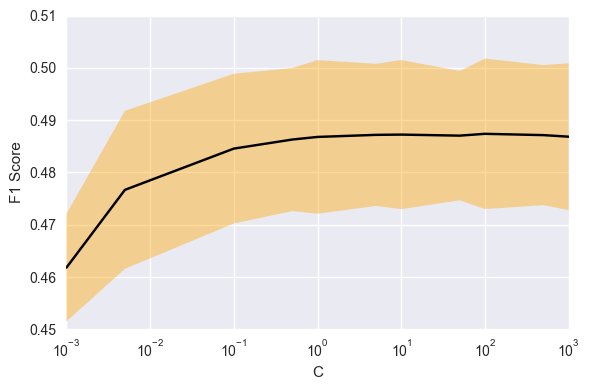

In [181]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

x  = [param['C'] for param in grid.cv_results_['params']]
y  = grid.cv_results_['mean_test_score']
dy = grid.cv_results_['std_test_score']

axes1.plot(x, y, color='black', ls='-');

axes1.fill_between(x, y-dy, y+dy, where=y+dy>=y-dy, facecolor='orange', interpolate=True, alpha=0.4)

axes1.set_xlim(min(x), max(x))
axes1.set_ylim(0.45, 0.51)
axes1.set_xscale('log')
axes1.set_xlabel('C')
axes1.set_ylabel('F1 Score')
#axes1.grid(False)
#axes1.set_facecolor('white');

fig.tight_layout();

# With TF-IDF Vectorization

Now let's include more complex TF-IDF Bag of Words type features to see how much that improves performance.

In [ ]:
# run the CountVectorizer on the event descriptions and event titles
'''
count_vect_desc  = CountVectorizer(stop_words='english', min_df=25,  ngram_range=(1, 3), analyzer='word')
count_vect_title = CountVectorizer(stop_words='english', min_df=25,  ngram_range=(1, 3), analyzer='word')
count_vect_camp  = CountVectorizer(stop_words='english', min_df=100, ngram_range=(3, 5), analyzer='char')
count_vect_loca  = CountVectorizer(stop_words='english', min_df=50,  ngram_range=(3, 5), analyzer='char')

X        = count_vect_desc.fit_transform(events['Description'].values);
X_titles = count_vect_title.fit_transform(events['Title'].values);
X_camp   = count_vect_camp.fit_transform([str(event) for event in events['Hosted by Camp'].fillna('').values]);
X_loca   = count_vect_camp.fit_transform([str(event) for event in events['Location'].fillna('').values]);

iX_desc  = X.shape[1]
iX_title = X_titles.shape[1]
iX_camp  = X_camp.shape[1]
iX_loca  = X_loca.shape[1]

print(X.shape)
print(X_titles.shape)
print(X_camp.shape)
print(X_loca.shape)

In [20]:
count_vect_desc  = CountVectorizer(stop_words='english', min_df=40,  ngram_range=(1, 3), analyzer='word')

X = count_vect_desc.fit_transform(events['Description'].values);

iX_desc  = X.shape[1]

print(X.shape)

(20165, 3097)


In [21]:
basic_features = ['Contact Email', 'URL', 'Located at Art', 'Event Length']

print(shape(X));
#print(shape(X_titles));
#print(shape(X_camp));
print(shape(events[days].values));
print(shape(events[basic_features].values));

desc_length = shape(X)[1]

#print(desc_length)

(20165, 3097)
(20165, 9)
(20165, 4)


In [ ]:
'''
enc = OneHotEncoder()
le  = LabelEncoder()

camps = events['Hosted by Camp'].fillna('')

events['Hosted by Camp'] = le.fit_transform(camps)

camps = enc.fit_transform(events[['Hosted by Camp']])

camps.toarray().shape

In [22]:
#X = sparse.csr_matrix(hstack((X.toarray(), X_titles.toarray(), X_camp.toarray(), X_handFeatures, 
#                              events[days].values, events[basic_features].values)))

#X = sparse.csr_matrix(hstack((X.toarray(), X_titles.toarray(), X_handFeatures, camps.toarray(), 
#                              events[days].values, events[basic_features].values)))

X = sparse.csr_matrix(hstack((X.toarray(), X_handFeatures, events[days].values, events[basic_features].values)))

print(shape(X))

(20165, 3137)


In [83]:
all_feature_names = ['str('+name+')' for name in count_vect_desc.get_feature_names()] + features + days + basic_features

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10082, 3137)
(10083, 3137)
(10082,)
(10083,)


In [24]:
clf = LogisticRegression().fit(X_train, y_train)

pred = clf.predict(X_test)

From the confusion matrix we can see what the most common types of mislabels are. On the top are the predicted labels. On the left are the true labels.

In [25]:
cf = confusion_matrix(y_test, pred)

df_cf = pd.DataFrame(cf, columns=labels, index=labels)

df_cf

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,239,16,113,0,11,21,102,2,32,2,17,7
Care/Support,11,156,88,1,8,1,46,7,39,0,5,10
Class/Workshop,24,38,2753,7,9,14,172,11,74,2,42,64
Fire,0,1,3,32,0,2,20,2,6,0,10,5
Food,0,8,23,0,244,4,116,4,10,0,6,4
Game,10,9,47,0,3,256,91,7,31,1,13,6
Gathering/Party,24,25,176,7,65,37,2061,7,103,15,87,34
Kid-friendly,1,3,36,0,6,10,21,57,34,0,4,9
Other,11,33,206,0,19,16,187,18,148,5,31,37
Parade,0,0,8,1,2,2,39,1,9,70,5,3


Lets normalize it by the total number of samples in each column to make it easier to read.

Predicted adult-oriented events are workshops or parties 23% of the time. Likewise care/support predictions are often classes and 'other' events. Food events are parties 19% of the time. These aren't necessarily mutually exclusive groups, so it may be difficult to reduce this particular type of error.

In [26]:
df_cf_norm = df_cf.copy()

for column in df_cf_norm.columns.values:
    df_cf_norm[column] = round(df_cf_norm[column]/df_cf_norm[column].values.sum(), 2)
    
df_cf_norm

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,0.73,0.05,0.03,0.00,0.03,0.05,0.03,0.02,0.06,0.02,0.02,0.02
Care/Support,0.03,0.50,0.02,0.02,0.02,0.00,0.01,0.06,0.07,0.00,0.01,0.03
Class/Workshop,0.07,0.12,0.75,0.12,0.02,0.04,0.06,0.09,0.13,0.02,0.06,0.16
Fire,0.00,0.00,0.00,0.54,0.00,0.01,0.01,0.02,0.01,0.00,0.01,0.01
Food,0.00,0.03,0.01,0.00,0.64,0.01,0.04,0.03,0.02,0.00,0.01,0.01
Game,0.03,0.03,0.01,0.00,0.01,0.67,0.03,0.06,0.06,0.01,0.02,0.02
Gathering/Party,0.07,0.08,0.05,0.12,0.17,0.10,0.66,0.06,0.19,0.15,0.13,0.09
Kid-friendly,0.00,0.01,0.01,0.00,0.02,0.03,0.01,0.46,0.06,0.00,0.01,0.02
Other,0.03,0.11,0.06,0.00,0.05,0.04,0.06,0.15,0.27,0.05,0.04,0.10
Parade,0.00,0.00,0.00,0.02,0.01,0.01,0.01,0.01,0.02,0.68,0.01,0.01


Let's take a look at the classification report to see what the F1 scores by class look like. Identification of workshops is great, but Kid-friendly and other events not so much.

In [27]:
print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.73      0.43      0.54       562
   Care/Support       0.50      0.42      0.46       372
 Class/Workshop       0.75      0.86      0.80      3210
           Fire       0.54      0.40      0.46        81
           Food       0.64      0.58      0.61       419
           Game       0.67      0.54      0.60       474
Gathering/Party       0.66      0.78      0.72      2641
   Kid-friendly       0.46      0.31      0.38       181
          Other       0.27      0.21      0.23       711
         Parade       0.68      0.50      0.58       140
    Performance       0.65      0.58      0.61       779
Ritual/Ceremony       0.49      0.37      0.42       513

    avg / total       0.65      0.66      0.65     10083





Let's get a more reliable measurement of the F1 score using 5-fold cross-validation.

In [84]:
scores = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='f1_micro', n_jobs=5)

print('Average F1 Score by CV = ' + str(np.mean(scores)))

Average F1 Score by CV = 0.6268472596991185


Let's run a GridSearch over LogisticRegression's regularization parameter to see what looks best. The black curve is the measured F1 score and the orange region corresponds to the standard deviation. A regularization parameter C of 0.1 is probably best.

In [109]:
params = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

grid = GridSearchCV(LogisticRegression(), param_grid=params, scoring='f1_micro', n_jobs=6, verbose=1, cv=10)

grid.fit(X, y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 110 out of 110 | elapsed: 23.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

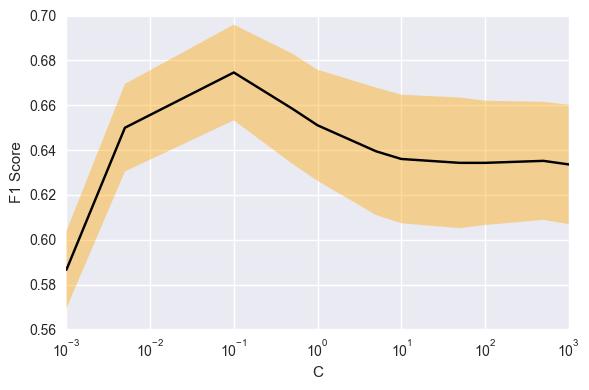

In [168]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

x  = [param['C'] for param in grid.cv_results_['params']]
y  = grid.cv_results_['mean_test_score']
dy = grid.cv_results_['std_test_score']

axes1.plot(x, y, color='black', ls='-');

axes1.fill_between(x, y-dy, y+dy, where=y+dy>=y-dy, facecolor='orange', interpolate=True, alpha=0.4)

axes1.set_xlim(min(x), max(x))
axes1.set_ylim(0.56, 0.7)
axes1.set_xscale('log')
axes1.set_xlabel('C')
axes1.set_ylabel('F1 Score')
#axes1.grid(False)
#axes1.set_facecolor('white');

fig.tight_layout();

# LightGBM

In [84]:
clf = lgb.LGBMClassifier().fit(X_train.toarray(), y_train, feature_name=all_feature_names)

pred = clf.predict(X_test.toarray())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [56]:
cf = confusion_matrix(y_test, pred)

df_cf = pd.DataFrame(cf, columns=labels, index=labels)

df_cf

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,199,11,163,0,6,24,138,3,6,4,6,2
Care/Support,10,84,132,0,7,5,97,3,25,1,2,6
Class/Workshop,20,14,2732,2,9,22,305,4,28,2,46,26
Fire,2,1,10,21,0,5,23,1,0,1,13,4
Food,3,3,76,0,132,5,180,5,4,1,7,3
Game,11,6,98,0,4,211,109,6,17,2,7,3
Gathering/Party,17,13,322,10,43,41,2063,1,28,20,67,16
Kid-friendly,1,9,58,1,4,9,46,28,16,1,8,0
Other,19,25,234,2,9,32,254,13,72,5,37,9
Parade,0,0,21,0,0,2,62,0,1,51,2,1


In [35]:
df_cf_norm = df_cf.copy()

for column in df_cf_norm.columns.values:
    df_cf_norm[column] = round(df_cf_norm[column]/df_cf_norm[column].values.sum(), 2)
    
df_cf_norm

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,0.68,0.06,0.04,0.00,0.03,0.06,0.04,0.05,0.03,0.04,0.01,0.01
Care/Support,0.03,0.47,0.03,0.00,0.03,0.01,0.03,0.05,0.11,0.01,0.00,0.03
Class/Workshop,0.07,0.08,0.65,0.05,0.04,0.06,0.08,0.06,0.12,0.02,0.08,0.14
Fire,0.01,0.01,0.00,0.51,0.00,0.01,0.01,0.02,0.00,0.01,0.02,0.02
Food,0.01,0.02,0.02,0.00,0.59,0.01,0.05,0.08,0.02,0.01,0.01,0.02
Game,0.04,0.03,0.02,0.00,0.02,0.55,0.03,0.09,0.07,0.02,0.01,0.02
Gathering/Party,0.06,0.07,0.08,0.24,0.19,0.11,0.57,0.02,0.12,0.20,0.12,0.09
Kid-friendly,0.00,0.05,0.01,0.02,0.02,0.02,0.01,0.42,0.07,0.01,0.01,0.00
Other,0.06,0.14,0.06,0.05,0.04,0.08,0.07,0.20,0.30,0.05,0.07,0.05
Parade,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.52,0.00,0.01


In [36]:
print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.68      0.35      0.46       562
   Care/Support       0.47      0.23      0.31       372
 Class/Workshop       0.65      0.85      0.74      3210
           Fire       0.51      0.26      0.34        81
           Food       0.59      0.32      0.41       419
           Game       0.55      0.45      0.49       474
Gathering/Party       0.57      0.78      0.66      2641
   Kid-friendly       0.42      0.15      0.23       181
          Other       0.30      0.10      0.15       711
         Parade       0.52      0.36      0.43       140
    Performance       0.60      0.43      0.50       779
Ritual/Ceremony       0.58      0.21      0.31       513

    avg / total       0.58      0.60      0.56     10083





In [ ]:
params = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

grid = GridSearchCV(LogisticRegression(), param_grid=params, scoring='f1_micro', n_jobs=6, verbose=1, cv=10)

grid.fit(X, y)

Redefining LGB's plot_importance() function to round the labels. Otherwise the endless decimals just dominate.

In [105]:
from lightgbm import LGBMModel

def plot_importance(booster, ax=None, height=0.2,
                    xlim=None, ylim=None, title='Feature importance',
                    xlabel='Feature importance', ylabel='Features',
                    importance_type='split', max_num_features=None,
                    ignore_zero=True, figsize=None, grid=True, **kwargs):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError('You must install matplotlib to plot importance.')

    if isinstance(booster, LGBMModel):
        booster = booster.booster_
    elif not isinstance(booster, Booster):
        raise TypeError('booster must be Booster or LGBMModel.')

    importance = booster.feature_importance(importance_type=importance_type)
    feature_name = booster.feature_name()

    if not len(importance):
        raise ValueError('Booster feature_importances are empty.')

    tuples = sorted(zip(feature_name, importance), key=lambda x: x[1])
    if ignore_zero:
        tuples = [x for x in tuples if x[1] > 0]
    if max_num_features is not None and max_num_features > 0:
        tuples = tuples[-max_num_features:]
    labels, values = zip(*tuples)

    if ax is None:
        if figsize is not None:
            check_not_tuple_of_2_elements(figsize, 'figsize')
        _, ax = plt.subplots(1, 1, figsize=figsize)

    ylocs = np.arange(len(values))
    ax.barh(ylocs, values, align='center', height=height, **kwargs)

    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, int(x), va='center', alpha=0.4, fontsize=9)

    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)

    if xlim is not None:
        check_not_tuple_of_2_elements(xlim, 'xlim')
    else:
        xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)

    if ylim is not None:
        check_not_tuple_of_2_elements(ylim, 'ylim')
    else:
        ylim = (-1, len(values))
    ax.set_ylim(ylim)

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(grid)
    return ax

By both metrics, the Event Length is the most important variables by a substantial margine. The hand crafted features also tend to be the most important. Words like party, stage, game, learn, yoga, parade, tournament, 18, and camp also tend to be really important.

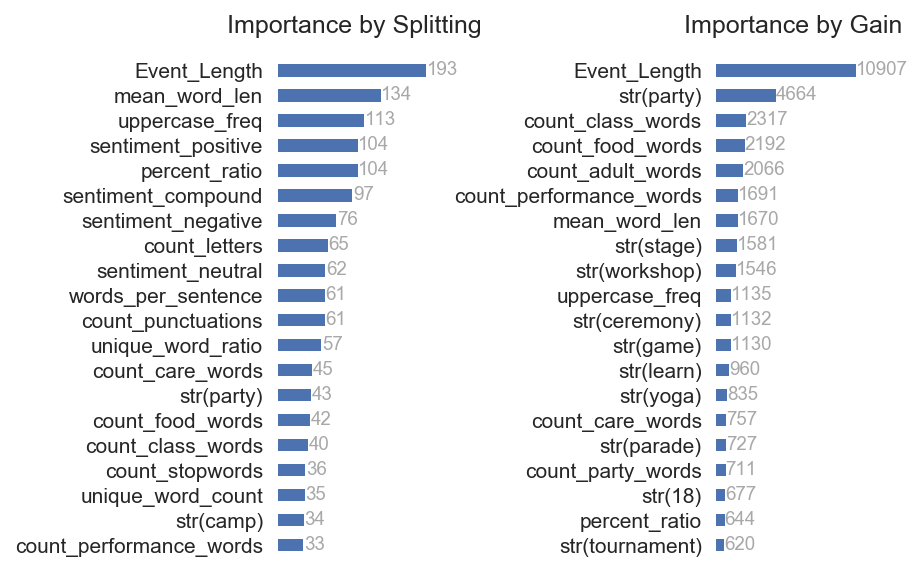

In [106]:
fig = plt.figure(figsize=(6, 4), dpi=150)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_importance(clf, height=0.5, ax=ax1, importance_type='split', xlabel='Feature Importance', ylabel=None, max_num_features=20)
plot_importance(clf, height=0.5, ax=ax2, importance_type='gain',  xlabel='Feature Importance', ylabel=None, max_num_features=20)

ax1.grid(False);ax2.grid(False);
ax1.set_title('Importance by Splitting');ax2.set_title('Importance by Gain');

ax1.set_facecolor('white');ax2.set_facecolor('white');
ax1.set_xlim(0, 200)
ax2.set_xlim(0, 12000)
ax1.set_xticklabels([]);ax2.set_xticklabels([]);
ax1.set_xlabel('');ax2.set_xlabel('');

fig.tight_layout()